In [6]:
import numpy as np
import pandas as pd
import argparse
from datetime import datetime
import random
import os
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
plt.style.use('seaborn')
import seaborn as sns
import time
import sys
import os
import scipy.stats as st
# from statsmodels.stats.weightstats import DescrStatsW
# import modules within repository
# from copy import deepcopy
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
%load_ext autoreload
%autoreload 2
from params import MEGLpParams
from scipy import stats
from utils.embedding_utils import metric_analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
%reload_ext autoreload
parser = argparse.ArgumentParser(description='RiemannianGNN')
args, _ = parser.parse_known_args()
MEGLpParams.add_params(parser)
args = parser.parse_args(args=[])

In [70]:
clinical_df = pd.read_csv(args.raw_clinical_file)
clinical_df

,Pre,Scan Index,ID,CogTr,diagnosis,pre_MMSE,pre_7MS,pre_BNT,pre_RSF_copy_time,pre_RSF_copy,...,post_sem_fluency_name,post_TMT_A_hits,post_TMT_A_time,post_TMT_B_hits,post_TMT_B_time,post_RBMT_profile,post_RBMT_global,age,sex,APOE
0,1,0,UMEC-002,1,1,30.0,89.0,60.0,49.0,22.0,...,24.0,24.0,44.0,24.0,77.0,22.0,11.0,70,1,33.0
1,0,1,UMEC-002,1,1,30.0,89.0,60.0,49.0,22.0,...,24.0,24.0,44.0,24.0,77.0,22.0,11.0,70,1,33.0
2,1,2,UMEC-020,1,1,30.0,79.0,NaN,NaN,NaN,...,21.0,24.0,43.0,20.0,89.0,24.0,12.0,72,1,33.0
3,0,3,UMEC-020,1,1,30.0,79.0,NaN,NaN,NaN,...,21.0,24.0,43.0,20.0,89.0,24.0,12.0,72,1,33.0
4,1,4,UMEC-022,1,1,29.0,62.0,49.0,115.0,21.0,...,15.0,24.0,55.0,24.0,97.0,NaN,10.0,78,2,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0,175,UMEC-213,2,2,29.0,73.0,57.0,45.0,22.0,...,19.0,24.0,41.0,24.0,89.0,24.0,12.0,67,1,33.0
176,1,176,UMEC-214,2,2,30.0,89.0,54.0,74.0,21.0,...,28.0,24.0,54.0,24.0,88.0,23.0,11.0,65,2,33.0
177,0,177,UMEC-214,2,2,30.0,89.0,54.0,74.0,21.0,...,28.0,24.0,54.0,24.0,88.0,23.0,11.0,65,2,33.0
178,1,178,UMEC-216,2,2,30.0,74.0,56.0,50.0,22.0,...,24.0,24.0,53.0,24.0,69.0,24.0,12.0,69,2,33.0


In [71]:
embedding_dir=os.path.join(os.getcwd(),'outputs',"stats","main_54")
full_stat_df=pd.read_csv(os.path.join(embedding_dir,"embedding_stats_avg5.csv"))
output_dir=os.path.join(embedding_dir,"stat_analysis")

In [72]:
def digest_stat_df(stat_df,stat_type,prob=False):
    print(c for c in stat_df.columns)
    
    cols_to_use=[c for c in stat_df.columns if stat_type.lower() in c.lower()]
    if prob:
        cols_to_use=[c for c in cols_to_use if 'prob' in c.lower()]
    else:
        cols_to_use=[c for c in cols_to_use if 'prob' not in c.lower()]
    return np.array(stat_df[cols_to_use]),cols_to_use

def slice_metric_df(stat_df_full,label_col,conditionals,title='',plot_save_path='',df_save_path=''):
    conditional_df=stat_df_full[conditionals]
    if len(conditional_df['ID'].unique())*2<=len(conditional_df['ID']):
        repeated=True
    else:
        repeated=False
    print(conditional_df.shape,'CONDITIONAL DF')
    scan_labels = conditional_df[label_col].values
    print(scan_labels,"SCAN LABELS")
    print(conditional_df['ID'],'ID LABELS')
    
    if min(scan_labels)>0:
        scan_labels=scan_labels-1  
        
    if label_col in ('diagnosis','diagnosis_inv'):
        group_labels = ['Healthy Control', 'SCD']
    elif label_col == 'CogTr':
        # group_labels=['Control','CogTr']
        group_labels=['CogTr','Control']
    elif label_col == 'Pre':
        group_labels=['Post','Pre']
    else:
        raise Exception('Unknown metric col: {}'.format(metric_col))
        
    cluster_labels=["pDMN","aDMN","DAN","FPN","VN","VAN","SN","SMN"]
        
    rc,rc_labels=digest_stat_df(conditional_df,stat_type='rad')
    wc,wc_labels=digest_stat_df(conditional_df,stat_type='coh')
    bc,bc_labels=digest_stat_df(conditional_df,stat_type='btw')
    
    age=np.array(conditional_df[['age']])
    wc=wc.astype(float)

    val_col=np.array(clinical_df[label_col])
    val_col=val_col-val_col.min()
#     print(val_col,'val col')
#     print(scan_labels,'graph met')
#     assert np.sum(np.abs((val_col-scan_labels)))==0
#     print('ALL EQUAL!')

    print(wc_labels,'WC LABELS')

#     metric_analysis(wc,cluster_labels,scan_labels,column_name=label_col,y_axis=['Cluster Cohesion'],plot_title=title,
#                     plot_save_path=plot_save_path+'_C',
#                     graph_label_names=group_labels,sort_vals=True,max_plot=8,clinical_df=conditional_df)
    print('rad')
    
    print(label_col,'label col')

    if repeated:
        metric_analysis(rc,cluster_labels, scan_labels,column_name=label_col,y_axis=['Cluster Radius from Origin'],
                    analyze_time=True,
                    plot_save_path=plot_save_path+'_R_time',df_save_path=df_save_path+'R.csv',
                    plot_title=title,graph_label_names=group_labels,sort_vals=True,max_plot=8,clinical_df=conditional_df)
    else:
        metric_analysis(rc,cluster_labels, scan_labels,column_name=label_col,y_axis=['Cluster Radius from Origin'],
                        plot_save_path=plot_save_path+'_R',df_save_path=df_save_path+'R.csv',
                        plot_title=title,graph_label_names=group_labels,sort_vals=True,max_plot=8,clinical_df=conditional_df)
#     print('btw clust')
#     metric_analysis(bc,bc_labels,scan_labels,y_axis=['Dist Btw Clusters'],column_name=['Dist Btw Clusters'],
#                     plot_save_path=plot_save_path+'_D',
#                     plot_title=title,graph_label_names=group_labels,sort_vals=True,max_plot=6,clinical_df=conditional_df)
#     metric_analysis(age,['age'], scan_labels,column_name=label_col,y_axis=['age'],
#                     plot_save_path=plot_save_path+'_A',df_save_path=df_save_path+'A.csv',
#                     plot_title=title,graph_label_names=group_labels,sort_vals=True,max_plot=1,clinical_df=conditional_df)

    

In [73]:
title_dict={'diagnosis':{1:'HC Group',2:'SCD Group',10:'All patients'},
 'CogTr':{1:'the Training Group',2:'No Training Group',10:'All patients'},
            'Pre':{0:'Second Scan',1:'First Scan',2:'Both Scans (Mixed Model)'}}

In [74]:
def run_all_slices_diagnosis(stat_df,title_dict,output_dir=''):
    print(output_dir,'OUTPUT')
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    output_plot_dir=os.path.join(output_dir,'plots')
    output_df_dir=os.path.join(output_dir,'dfs')
    if not os.path.exists(output_plot_dir):
        os.mkdir(output_plot_dir)
    if not os.path.exists(output_df_dir):
        os.mkdir(output_df_dir)
        
    for train_val,train_title in title_dict['CogTr'].items():
        for pre_val,pre_title in title_dict['Pre'].items():
            train_title=title_dict['CogTr'][train_val]
            print(train_val,pre_title)
            
            if pre_val<=1 and train_val<=2:
                conditionals=((clinical_df['CogTr']==train_val) & (clinical_df['Pre']==pre_val))
#                 print(conditionals.shape,'DOUBLE TROUBL')
                
#                 sjsjs
            elif pre_val>1 and train_val<=2:
                conditionals=((clinical_df['CogTr']==train_val))
                print('both scans!!')
                print(conditionals.shape,'!!')
            elif pre_val<=1 and train_val>2:
                conditionals=((clinical_df['Pre']==pre_val))
            elif pre_val>1 and train_val>2:
                conditionals=((clinical_df['CogTr']<20))
            title='{} of {}'.format(pre_title,train_title)
            print(title,'title')
            plot_save_path=os.path.join(output_plot_dir,'CG{}_PRE{}'.format(train_val,pre_val))
            df_save_path=os.path.join(output_df_dir,'CG{}_PRE{}'.format(train_val,pre_val))
            slice_metric_df(stat_df,label_col='diagnosis',conditionals =conditionals,
                            title=title,plot_save_path=plot_save_path,df_save_path=df_save_path)

In [75]:
def run_all_slices_training(stat_df,title_dict,output_dir=''):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_plot_dir=os.path.join(output_dir,'plots')
    output_df_dir=os.path.join(output_dir,'dfs')
    if not os.path.exists(output_plot_dir):
        os.mkdir(output_plot_dir)
    if not os.path.exists(output_df_dir):
        os.mkdir(output_df_dir)
        
    for diag_val,diag_title in title_dict['diagnosis'].items():
        for pre_val,pre_title in title_dict['Pre'].items():
            print(diag_val,pre_title)
            
            if pre_val<=1 and diag_val<=2:
                conditionals=((clinical_df['diagnosis']==diag_val) & (clinical_df['Pre']==pre_val))
#                 print(conditionals.shape,'DOUBLE TROUBL')
                
#                 sjsjs
            elif pre_val>1 and diag_val<=2:
                conditionals=((clinical_df['diagnosis']==diag_val))
                print('both scans!!')
                print(conditionals.shape,'!!')
            elif pre_val<=1 and diag_val>2:
                conditionals=((clinical_df['Pre']==pre_val))
            elif pre_val>1 and diag_val>2:
                conditionals=((clinical_df['diagnosis']<20))
            title='{} of {}'.format(pre_title,diag_title)
#             output_path=os.path.join(output_dir,'D{}_PRE{}'.format(diag_val,pre_val))

            plot_save_path=os.path.join(output_plot_dir,'D{}_PRE{}'.format(diag_val,pre_val))
            df_save_path=os.path.join(output_df_dir,'D{}_PRE{}'.format(diag_val,pre_val))
            slice_metric_df(stat_df,label_col='CogTr',conditionals =conditionals,
                            title=title,plot_save_path=plot_save_path,df_save_path=df_save_path)

C:\Users\coleb\OneDrive\Desktop\Fall 2021\Neuro\hyperBrain\outputs\stats\main_54\stat_analysis OUTPUT
1 Second Scan
Second Scan of the Training Group title
(46, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2] SCAN LABELS
1     UMEC-002
3     UMEC-020
5     UMEC-022
7     UMEC-026
9     UMEC-028
11    UMEC-031
13    UMEC-038
15    UMEC-066
17    UMEC-073
19    UMEC-075
21    UMEC-079
23    UMEC-082
25    UMEC-083
27    UMEC-124
29    UMEC-125
31    UMEC-147
33    UMEC-160
35    UMEC-161
37    UMEC-186
39    UMEC-208
41    UMEC-225
43    UMEC-226
45    UMEC-004
47    UMEC-005
49    UMEC-017
51    UMEC-030
53    UMEC-032
55    UMEC-053
57    UMEC-115
59    UMEC-132
61    UMEC-146
63    UMEC-155
65    UMEC-157
67    UMEC-159
69    UMEC-162
71    UMEC-164
73    UMEC-168
75    UMEC-173
77    UMEC-174
79    UMEC-176
81    UMEC-192
83    UMEC-194
85    UMEC-201
87    UMEC-206
89    UMEC-217
91    UMEC-219
Name: ID, dtype: objec

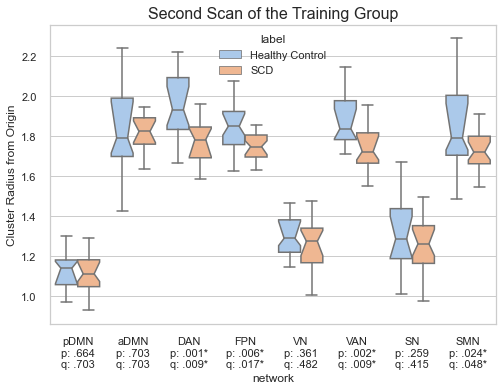

1 First Scan
First Scan of the Training Group title
(46, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2] SCAN LABELS
0     UMEC-002
2     UMEC-020
4     UMEC-022
6     UMEC-026
8     UMEC-028
10    UMEC-031
12    UMEC-038
14    UMEC-066
16    UMEC-073
18    UMEC-075
20    UMEC-079
22    UMEC-082
24    UMEC-083
26    UMEC-124
28    UMEC-125
30    UMEC-147
32    UMEC-160
34    UMEC-161
36    UMEC-186
38    UMEC-208
40    UMEC-225
42    UMEC-226
44    UMEC-004
46    UMEC-005
48    UMEC-017
50    UMEC-030
52    UMEC-032
54    UMEC-053
56    UMEC-115
58    UMEC-132
60    UMEC-146
62    UMEC-155
64    UMEC-157
66    UMEC-159
68    UMEC-162
70    UMEC-164
72    UMEC-168
74    UMEC-173
76    UMEC-174
78    UMEC-176
80    UMEC-192
82    UMEC-194
84    UMEC-201
86    UMEC-206
88    UMEC-217
90    UMEC-219
Name: ID, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466C51B8C8>
<generator object

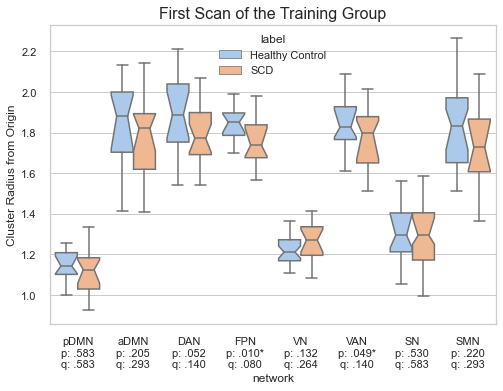

1 Both Scans (Mixed Model)
both scans!!
(180,) !!
Both Scans (Mixed Model) of the Training Group title
(92, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] SCAN LABELS
0     UMEC-002
1     UMEC-002
2     UMEC-020
3     UMEC-020
4     UMEC-022
        ...   
87    UMEC-206
88    UMEC-217
89    UMEC-217
90    UMEC-219
91    UMEC-219
Name: ID, Length: 92, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x0000014669165DC8>
<generator object digest_stat_df.<locals>.<genexpr> at 0x0000014669165DC8>
<generator object digest_stat_df.<locals>.<genexpr> at 0x0000014669165DC8>
['pDMN_Coh', 'aDMN_Coh', 'DAN_Coh', 'FPN_Coh', 'VN_Coh', 'VAN_Coh', 'SN_Coh', 'SMN_Coh'] WC LABELS
rad
diagnosis label col
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1

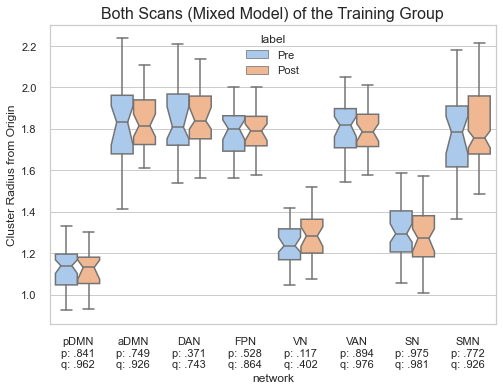

2 Second Scan
Second Scan of No Training Group title
(44, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2] SCAN LABELS
93     UMEC-008
95     UMEC-009
97     UMEC-076
99     UMEC-078
101    UMEC-080
103    UMEC-081
105    UMEC-127
107    UMEC-136
109    UMEC-138
111    UMEC-150
113    UMEC-181
115    UMEC-182
117    UMEC-184
119    UMEC-185
121    UMEC-190
123    UMEC-196
125    UMEC-197
127    UMEC-210
129    UMEC-227
131    UMEC-036
133    UMEC-039
135    UMEC-054
137    UMEC-060
139    UMEC-061
141    UMEC-064
143    UMEC-068
145    UMEC-100
147    UMEC-101
149    UMEC-104
151    UMEC-121
153    UMEC-139
155    UMEC-141
157    UMEC-145
159    UMEC-148
161    UMEC-151
163    UMEC-152
165    UMEC-154
167    UMEC-163
169    UMEC-172
171    UMEC-191
173    UMEC-205
175    UMEC-213
177    UMEC-214
179    UMEC-216
Name: ID, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0A48>
<gener

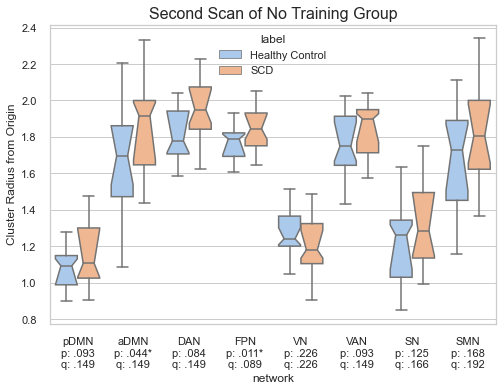

2 First Scan
First Scan of No Training Group title
(44, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2] SCAN LABELS
92     UMEC-008
94     UMEC-009
96     UMEC-076
98     UMEC-078
100    UMEC-080
102    UMEC-081
104    UMEC-127
106    UMEC-136
108    UMEC-138
110    UMEC-150
112    UMEC-181
114    UMEC-182
116    UMEC-184
118    UMEC-185
120    UMEC-190
122    UMEC-196
124    UMEC-197
126    UMEC-210
128    UMEC-227
130    UMEC-036
132    UMEC-039
134    UMEC-054
136    UMEC-060
138    UMEC-061
140    UMEC-064
142    UMEC-068
144    UMEC-100
146    UMEC-101
148    UMEC-104
150    UMEC-121
152    UMEC-139
154    UMEC-141
156    UMEC-145
158    UMEC-148
160    UMEC-151
162    UMEC-152
164    UMEC-154
166    UMEC-163
168    UMEC-172
170    UMEC-191
172    UMEC-205
174    UMEC-213
176    UMEC-214
178    UMEC-216
Name: ID, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB05C8>
<generat

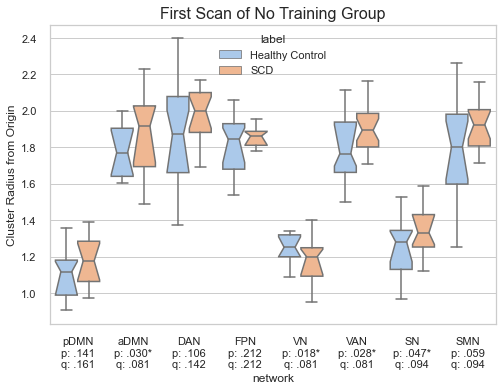

2 Both Scans (Mixed Model)
both scans!!
(180,) !!
Both Scans (Mixed Model) of No Training Group title
(88, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2] SCAN LABELS
92     UMEC-008
93     UMEC-008
94     UMEC-009
95     UMEC-009
96     UMEC-076
         ...   
175    UMEC-213
176    UMEC-214
177    UMEC-214
178    UMEC-216
179    UMEC-216
Name: ID, Length: 88, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
['pDMN_Coh', 'aDMN_Coh', 'DAN_Coh', 'FPN_Coh', 'VN_Coh', 'VAN_Coh', 'SN_Coh', 'SMN_Coh'] WC LABELS
rad
diagnosis label col
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

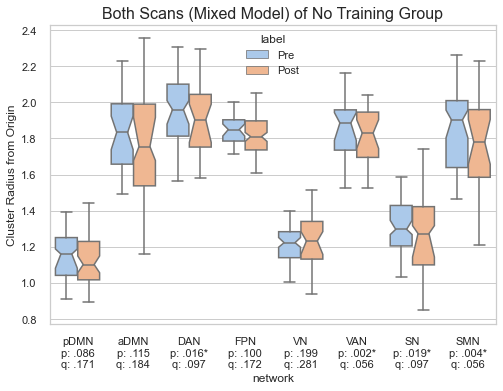

10 Second Scan
Second Scan of All patients title
(90, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] SCAN LABELS
1      UMEC-002
3      UMEC-020
5      UMEC-022
7      UMEC-026
9      UMEC-028
         ...   
171    UMEC-191
173    UMEC-205
175    UMEC-213
177    UMEC-214
179    UMEC-216
Name: ID, Length: 90, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
['pDMN_Coh', 'aDMN_Coh', 'DAN_Coh', 'FPN_Coh', 'VN_Coh', 'VAN_Coh', 'SN_Coh', 'SMN_Coh'] WC LABELS
rad
diagnosis label col
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1

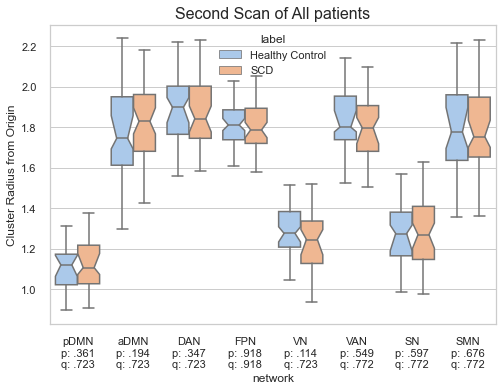

10 First Scan
First Scan of All patients title
(90, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] SCAN LABELS
0      UMEC-002
2      UMEC-020
4      UMEC-022
6      UMEC-026
8      UMEC-028
         ...   
170    UMEC-191
172    UMEC-205
174    UMEC-213
176    UMEC-214
178    UMEC-216
Name: ID, Length: 90, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
['pDMN_Coh', 'aDMN_Coh', 'DAN_Coh', 'FPN_Coh', 'VN_Coh', 'VAN_Coh', 'SN_Coh', 'SMN_Coh'] WC LABELS
rad
diagnosis label col
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1

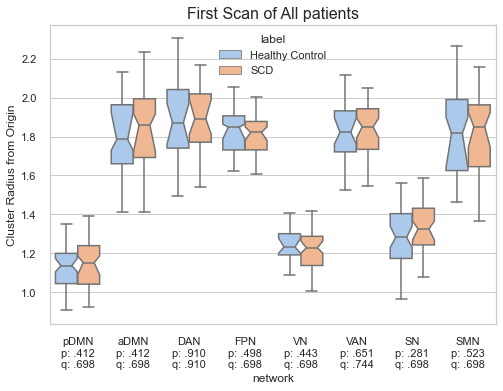

10 Both Scans (Mixed Model)
Both Scans (Mixed Model) of All patients title
(180, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] SCAN LABELS
0      UMEC-002
1      UMEC-002
2      UMEC-020
3      UMEC-020
4      UMEC-022
         ...   
175    UMEC-213
176    UMEC-214
177    UMEC-214
178    UMEC-216
179    UMEC-216
Name: ID, Length: 180, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
['pDMN_Coh', 'aDMN_Coh', 'DAN_Coh', 'FPN_Coh', 'VN_Coh', 'VAN_Coh', 'SN_C

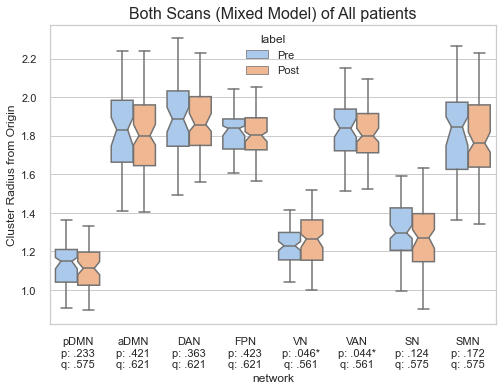

In [76]:
run_all_slices_diagnosis(full_stat_df,title_dict,output_dir)

1 Second Scan
(41, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2] SCAN LABELS
1      UMEC-002
3      UMEC-020
5      UMEC-022
7      UMEC-026
9      UMEC-028
11     UMEC-031
13     UMEC-038
15     UMEC-066
17     UMEC-073
19     UMEC-075
21     UMEC-079
23     UMEC-082
25     UMEC-083
27     UMEC-124
29     UMEC-125
31     UMEC-147
33     UMEC-160
35     UMEC-161
37     UMEC-186
39     UMEC-208
41     UMEC-225
43     UMEC-226
93     UMEC-008
95     UMEC-009
97     UMEC-076
99     UMEC-078
101    UMEC-080
103    UMEC-081
105    UMEC-127
107    UMEC-136
109    UMEC-138
111    UMEC-150
113    UMEC-181
115    UMEC-182
117    UMEC-184
119    UMEC-185
121    UMEC-190
123    UMEC-196
125    UMEC-197
127    UMEC-210
129    UMEC-227
Name: ID, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CED1848>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466E9B1F48>
<generator object digest

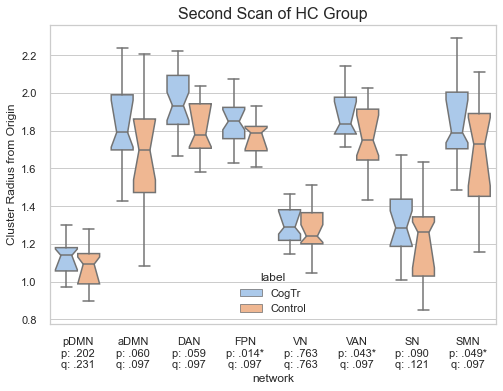

1 First Scan
(41, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2] SCAN LABELS
0      UMEC-002
2      UMEC-020
4      UMEC-022
6      UMEC-026
8      UMEC-028
10     UMEC-031
12     UMEC-038
14     UMEC-066
16     UMEC-073
18     UMEC-075
20     UMEC-079
22     UMEC-082
24     UMEC-083
26     UMEC-124
28     UMEC-125
30     UMEC-147
32     UMEC-160
34     UMEC-161
36     UMEC-186
38     UMEC-208
40     UMEC-225
42     UMEC-226
92     UMEC-008
94     UMEC-009
96     UMEC-076
98     UMEC-078
100    UMEC-080
102    UMEC-081
104    UMEC-127
106    UMEC-136
108    UMEC-138
110    UMEC-150
112    UMEC-181
114    UMEC-182
116    UMEC-184
118    UMEC-185
120    UMEC-190
122    UMEC-196
124    UMEC-197
126    UMEC-210
128    UMEC-227
Name: ID, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CED1348>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466E9B1F48>
<generator object digest_

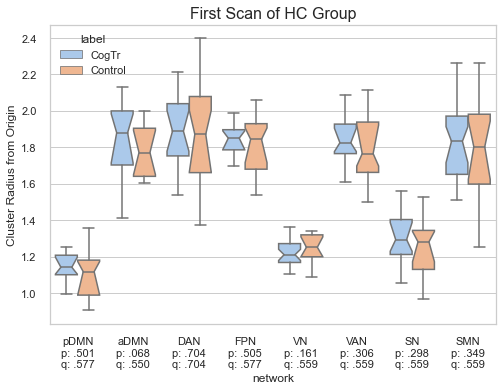

1 Both Scans (Mixed Model)
both scans!!
(180,) !!
(82, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2] SCAN LABELS
0      UMEC-002
1      UMEC-002
2      UMEC-020
3      UMEC-020
4      UMEC-022
         ...   
125    UMEC-197
126    UMEC-210
127    UMEC-210
128    UMEC-227
129    UMEC-227
Name: ID, Length: 82, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466E9B1F48>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466E9B1F48>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466E9B1F48>
['pDMN_Coh', 'aDMN_Coh', 'DAN_Coh', 'FPN_Coh', 'VN_Coh', 'VAN_Coh', 'SN_Coh', 'SMN_Coh'] WC LABELS
rad
CogTr label col
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1] val col
[0 

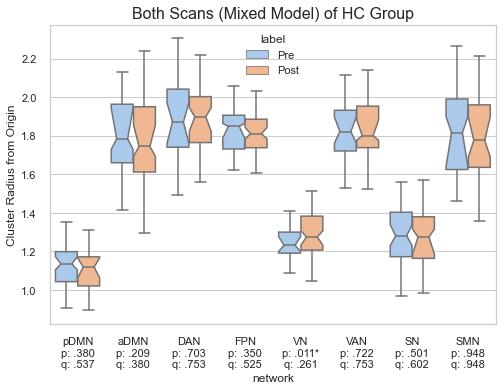

2 Second Scan
(49, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2] SCAN LABELS
45     UMEC-004
47     UMEC-005
49     UMEC-017
51     UMEC-030
53     UMEC-032
55     UMEC-053
57     UMEC-115
59     UMEC-132
61     UMEC-146
63     UMEC-155
65     UMEC-157
67     UMEC-159
69     UMEC-162
71     UMEC-164
73     UMEC-168
75     UMEC-173
77     UMEC-174
79     UMEC-176
81     UMEC-192
83     UMEC-194
85     UMEC-201
87     UMEC-206
89     UMEC-217
91     UMEC-219
131    UMEC-036
133    UMEC-039
135    UMEC-054
137    UMEC-060
139    UMEC-061
141    UMEC-064
143    UMEC-068
145    UMEC-100
147    UMEC-101
149    UMEC-104
151    UMEC-121
153    UMEC-139
155    UMEC-141
157    UMEC-145
159    UMEC-148
161    UMEC-151
163    UMEC-152
165    UMEC-154
167    UMEC-163
169    UMEC-172
171    UMEC-191
173    UMEC-205
175    UMEC-213
177    UMEC-214
179    UMEC-216
Name: ID, dtype: object ID LABELS
<generator object digest_stat_

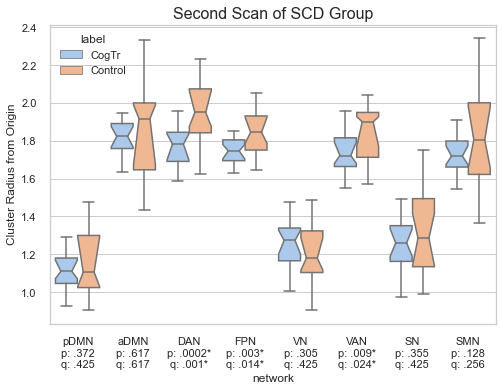

2 First Scan
(49, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2] SCAN LABELS
44     UMEC-004
46     UMEC-005
48     UMEC-017
50     UMEC-030
52     UMEC-032
54     UMEC-053
56     UMEC-115
58     UMEC-132
60     UMEC-146
62     UMEC-155
64     UMEC-157
66     UMEC-159
68     UMEC-162
70     UMEC-164
72     UMEC-168
74     UMEC-173
76     UMEC-174
78     UMEC-176
80     UMEC-192
82     UMEC-194
84     UMEC-201
86     UMEC-206
88     UMEC-217
90     UMEC-219
130    UMEC-036
132    UMEC-039
134    UMEC-054
136    UMEC-060
138    UMEC-061
140    UMEC-064
142    UMEC-068
144    UMEC-100
146    UMEC-101
148    UMEC-104
150    UMEC-121
152    UMEC-139
154    UMEC-141
156    UMEC-145
158    UMEC-148
160    UMEC-151
162    UMEC-152
164    UMEC-154
166    UMEC-163
168    UMEC-172
170    UMEC-191
172    UMEC-205
174    UMEC-213
176    UMEC-214
178    UMEC-216
Name: ID, dtype: object ID LABELS
<generator object digest_stat_d

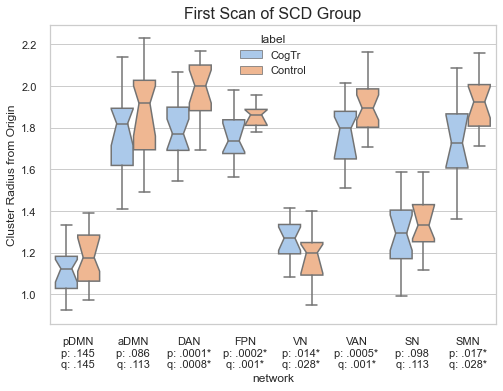

2 Both Scans (Mixed Model)
both scans!!
(180,) !!
(98, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] SCAN LABELS
44     UMEC-004
45     UMEC-004
46     UMEC-005
47     UMEC-005
48     UMEC-017
         ...   
175    UMEC-213
176    UMEC-214
177    UMEC-214
178    UMEC-216
179    UMEC-216
Name: ID, Length: 98, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0648>
['pDMN_Coh', 'aDMN_Coh', 'DAN_Coh', 'FPN_Coh', 'VN_Coh', 'VAN_Coh', 'SN_Coh', 'SMN_Coh'] WC LABELS
rad
CogTr label col
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

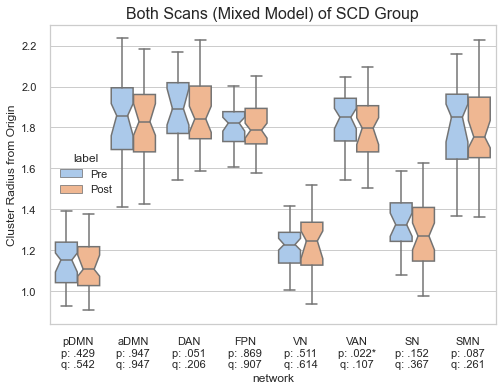

10 Second Scan
(90, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] SCAN LABELS
1      UMEC-002
3      UMEC-020
5      UMEC-022
7      UMEC-026
9      UMEC-028
         ...   
171    UMEC-191
173    UMEC-205
175    UMEC-213
177    UMEC-214
179    UMEC-216
Name: ID, Length: 90, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB07C8>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CED12C8>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CED12C8>
['pDMN_Coh', 'aDMN_Coh', 'DAN_Coh', 'FPN_Coh', 'VN_Coh', 'VAN_Coh', 'SN_Coh', 'SMN_Coh'] WC LABELS
rad
CogTr label col
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] val col
[0 0 0

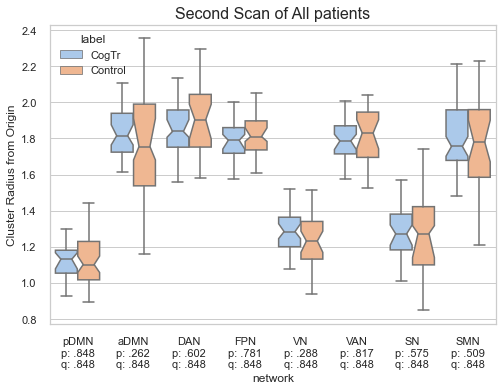

10 First Scan
(90, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] SCAN LABELS
0      UMEC-002
2      UMEC-020
4      UMEC-022
6      UMEC-026
8      UMEC-028
         ...   
170    UMEC-191
172    UMEC-205
174    UMEC-213
176    UMEC-214
178    UMEC-216
Name: ID, Length: 90, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0A48>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0A48>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0A48>
['pDMN_Coh', 'aDMN_Coh', 'DAN_Coh', 'FPN_Coh', 'VN_Coh', 'VAN_Coh', 'SN_Coh', 'SMN_Coh'] WC LABELS
rad
CogTr label col
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] val col
[0 0 0 

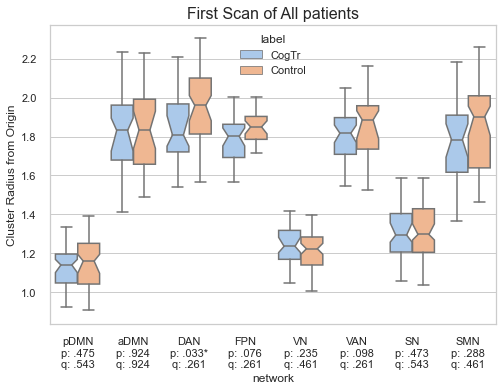

10 Both Scans (Mixed Model)
(180, 164) CONDITIONAL DF
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] SCAN LABELS
0      UMEC-002
1      UMEC-002
2      UMEC-020
3      UMEC-020
4      UMEC-022
         ...   
175    UMEC-213
176    UMEC-214
177    UMEC-214
178    UMEC-216
179    UMEC-216
Name: ID, Length: 180, dtype: object ID LABELS
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0AC8>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0AC8>
<generator object digest_stat_df.<locals>.<genexpr> at 0x000001466CEB0AC8>
['pDMN_Coh', 'aDMN_Coh', 'DAN_Coh', 'FPN_Coh', 'VN_Coh', 'VAN_Coh', 'SN_Coh', 'SMN_Coh'] WC LABELS
rad
CogTr label col
[

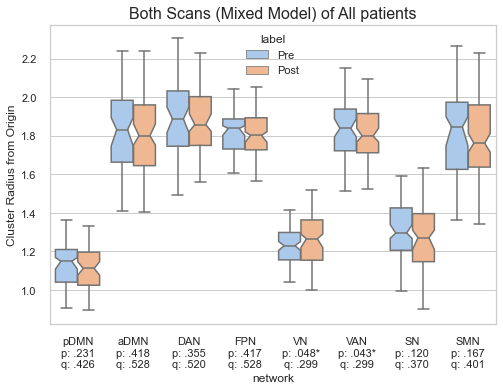

In [77]:
run_all_slices_training(full_stat_df,title_dict,output_dir)

In [39]:
conditionals=((clinical_df['CogTr']<20))
title='Both scans of All Patients'
output_path=os.path.join(output_dir,'DG10_PRE2')
slice_metric_df(full_stat_df,label_col='diagnosis',conditionals =conditionals,
                title=title,plot_save_path=output_path)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\coleb\\OneDrive\\Desktop\\Fall 2021\\Neuro\\hyperBrain\\share_data\\embedding_stats_avg5.csv'

In [ ]:
conditionals=((clinical_df['CogTr']==1) & (clinical_df['Pre']==0))

# conditionals=((clinical_df['CogTr']==1))
print(conditionals)
slice_metric_df(full_stat_df,label_col='diagnosis',conditionals = conditionals,title=title)

In [ ]:
clinical_df['ID']